In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Choose four different stocks from the S&P500 index
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

# Download adjusted closing prices
start_date = '2021-01-01'
end_date = '2022-12-31'
prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = prices.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


In [6]:
investment = 1000000# Suppose we invest 1.000.000$ on day n

## Non-parametric approach with equal weights put on past observations

In [15]:
# Calculate VaR and ES at 95% and 99% levels
def calculate_var_es(returns, level):
    var = np.percentile(returns, 100 - level, interpolation='lower')
    es = np.mean(returns[returns <= var])
    return var, es

# Calculate 1-day VaR and ES for each stock
for ticker in tickers:
    var_95, es_95 = calculate_var_es(returns[ticker], 95)
    var_99, es_99 = calculate_var_es(returns[ticker], 99)
    
    # Calculate actual change for the $1 million investment
    var_95_actual = var_95 * investment
    es_95_actual = es_95 * investment
    var_99_actual = var_99 * investment
    es_99_actual = es_99 * investment
    
    print(f"{ticker} - 95% VaR: {var_95*100:.2f}% ({var_95_actual:.2f} USD), 95% ES: {es_95*100:.2f}% ({es_95_actual:.2f} USD)")
    print(f"{ticker} - 99% VaR: {var_99*100:.2f}% ({var_99_actual:.2f} USD), 99% ES: {es_99*100:.2f}% ({es_99_actual:.2f} USD)")
    print('----------------------------------------------------------------------')

AAPL - 95% VaR: -3.32% (-33190.06 USD), 95% ES: -4.08% (-40847.48 USD)
AAPL - 99% VaR: -4.69% (-46854.36 USD), 99% ES: -5.31% (-53104.92 USD)
----------------------------------------------------------------------
MSFT - 95% VaR: -2.94% (-29355.24 USD), 95% ES: -4.03% (-40308.05 USD)
MSFT - 99% VaR: -4.36% (-43554.81 USD), 99% ES: -5.28% (-52772.61 USD)
----------------------------------------------------------------------
GOOGL - 95% VaR: -3.30% (-33030.20 USD), 95% ES: -4.40% (-43965.24 USD)
GOOGL - 99% VaR: -4.71% (-47075.52 USD), 99% ES: -5.96% (-59564.12 USD)
----------------------------------------------------------------------
AMZN - 95% VaR: -3.70% (-37026.43 USD), 95% ES: -5.76% (-57561.26 USD)
AMZN - 99% VaR: -7.06% (-70575.28 USD), 99% ES: -8.53% (-85336.42 USD)
----------------------------------------------------------------------


## Backtesting

## Non-parametric approach with probability weighting

In [21]:
def probabilityWeighting(n, l=0.995):
    return np.array([((1 - l)*l**(n-i))/(1 - l**n) for i in range(1, n+1)])

In [55]:

# Calculate VaR and ES with probability weighting
def calculate_prob_weighted_var_es(returns, level, n):
    weights = probabilityWeighting(n)
    sorted_returns = np.sort(returns)[-n:]
    accumulated_weights = np.cumsum(weights)
    
    idx = np.where(accumulated_weights > level)[0][0]
    var = -sorted_returns[idx]
    es = -((sorted_returns[:idx] * weights[:idx]).sum() + (level - accumulated_weights[idx-1]) * weights[idx]) / level
    
    return var, es

# Calculate 1-day VaR and ES for each stock
n = 252
for ticker in tickers:
    var_95, es_95 = calculate_prob_weighted_var_es(returns[ticker], 0.05, n)
    var_99, es_99 = calculate_prob_weighted_var_es(returns[ticker], 0.01, n)
    
    # Calculate actual change for the $1 million investment
    var_95_actual = var_95 * investment
    es_95_actual = es_95 * investment
    var_99_actual = var_99 * investment
    es_99_actual = es_99 * investment
    
    print(f"{ticker} - 95% Prob Weighted VaR: {var_95*100:.2f}% ({var_95_actual:.2f} USD), 95% Prob Weighted ES: {es_95*100:.2f}% ({es_95_actual:.2f} USD)")
    print(f"{ticker} - 99% Prob Weighted VaR: {var_99*100:.2f}% ({var_99_actual:.2f} USD), 99% Prob Weighted ES: {es_99*100:.2f}% ({es_99_actual:.2f} USD)")
    print('----------------------------------------------------------------------')

AAPL - 95% Prob Weighted VaR: -0.18% (-1804.03 USD), 95% Prob Weighted ES: -0.12% (-1162.23 USD)
AAPL - 99% Prob Weighted VaR: -0.05% (-502.04 USD), 99% Prob Weighted ES: -0.05% (-520.71 USD)
----------------------------------------------------------------------
MSFT - 95% Prob Weighted VaR: -0.15% (-1484.11 USD), 95% Prob Weighted ES: -0.08% (-780.62 USD)
MSFT - 99% Prob Weighted VaR: -0.01% (-99.97 USD), 99% Prob Weighted ES: -0.04% (-381.27 USD)
----------------------------------------------------------------------
GOOGL - 95% Prob Weighted VaR: -0.23% (-2318.51 USD), 95% Prob Weighted ES: -0.14% (-1422.08 USD)
GOOGL - 99% Prob Weighted VaR: -0.09% (-908.81 USD), 99% Prob Weighted ES: -0.10% (-1032.57 USD)
----------------------------------------------------------------------
AMZN - 95% Prob Weighted VaR: -0.18% (-1849.40 USD), 95% Prob Weighted ES: -0.08% (-824.02 USD)
AMZN - 99% Prob Weighted VaR: 0.01% (148.51 USD), 99% Prob Weighted ES: -0.02% (-166.48 USD)
---------------------

## Backtesting

## Parametric model using the normal distribution

In [40]:
def parametric_normal_var_es(returns, alpha, days=252):
    mean_return = 0  # Assumption - we could estimate this as well
    volatility = np.std(returns.values[-days:])  # standard deviation of daily returns
    var = -volatility * sps.norm.ppf(alpha, loc=mean_return, scale=1)
    es = volatility * (sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1))) / alpha
    return var, es

for ticker in tickers:
    var_95, es_95 = parametric_normal_var_es(returns[ticker], 0.05)
    var_99, es_99 = parametric_normal_var_es(returns[ticker], 0.01)
    
    # Calculate actual change for the $1 million investment
    var_95_actual = var_95 * investment
    es_95_actual = es_95 * investment
    var_99_actual = var_99 * investment
    es_99_actual = es_99 * investment
    
    print(f"{ticker} - 95% Normal VaR: {var_95*100:.2f}% ({var_95_actual:.2f} USD), 95% Normal ES: {es_95*100:.2f}% ({es_95_actual:.2f} USD)")
    print(f"{ticker} - 99% Normal VaR: {var_99*100:.2f}% ({var_99_actual:.2f} USD), 99% Normal ES: {es_99*100:.2f}% ({es_99_actual:.2f} USD)")
    print('----------------------------------------------------------------------')

AAPL - 95% Normal VaR: 3.68% (36841.11 USD), 95% Normal ES: 4.62% (46200.24 USD)
AAPL - 99% Normal VaR: 5.21% (52105.09 USD), 99% Normal ES: 5.97% (59694.95 USD)
----------------------------------------------------------------------
MSFT - 95% Normal VaR: 3.65% (36453.67 USD), 95% Normal ES: 4.57% (45714.38 USD)
MSFT - 99% Normal VaR: 5.16% (51557.13 USD), 99% Normal ES: 5.91% (59067.17 USD)
----------------------------------------------------------------------
GOOGL - 95% Normal VaR: 3.99% (39896.60 USD), 95% Normal ES: 5.00% (50031.95 USD)
GOOGL - 99% Normal VaR: 5.64% (56426.52 USD), 99% Normal ES: 6.46% (64645.87 USD)
----------------------------------------------------------------------
AMZN - 95% Normal VaR: 5.17% (51690.58 USD), 95% Normal ES: 6.48% (64822.07 USD)
AMZN - 99% Normal VaR: 7.31% (73106.97 USD), 99% Normal ES: 8.38% (83756.06 USD)
----------------------------------------------------------------------


## Backtesting

Backtesting results for AAPL:
Number of exceedances at 95% confidence level: 25.0
Number of exceedances at 99% confidence level: 6.0


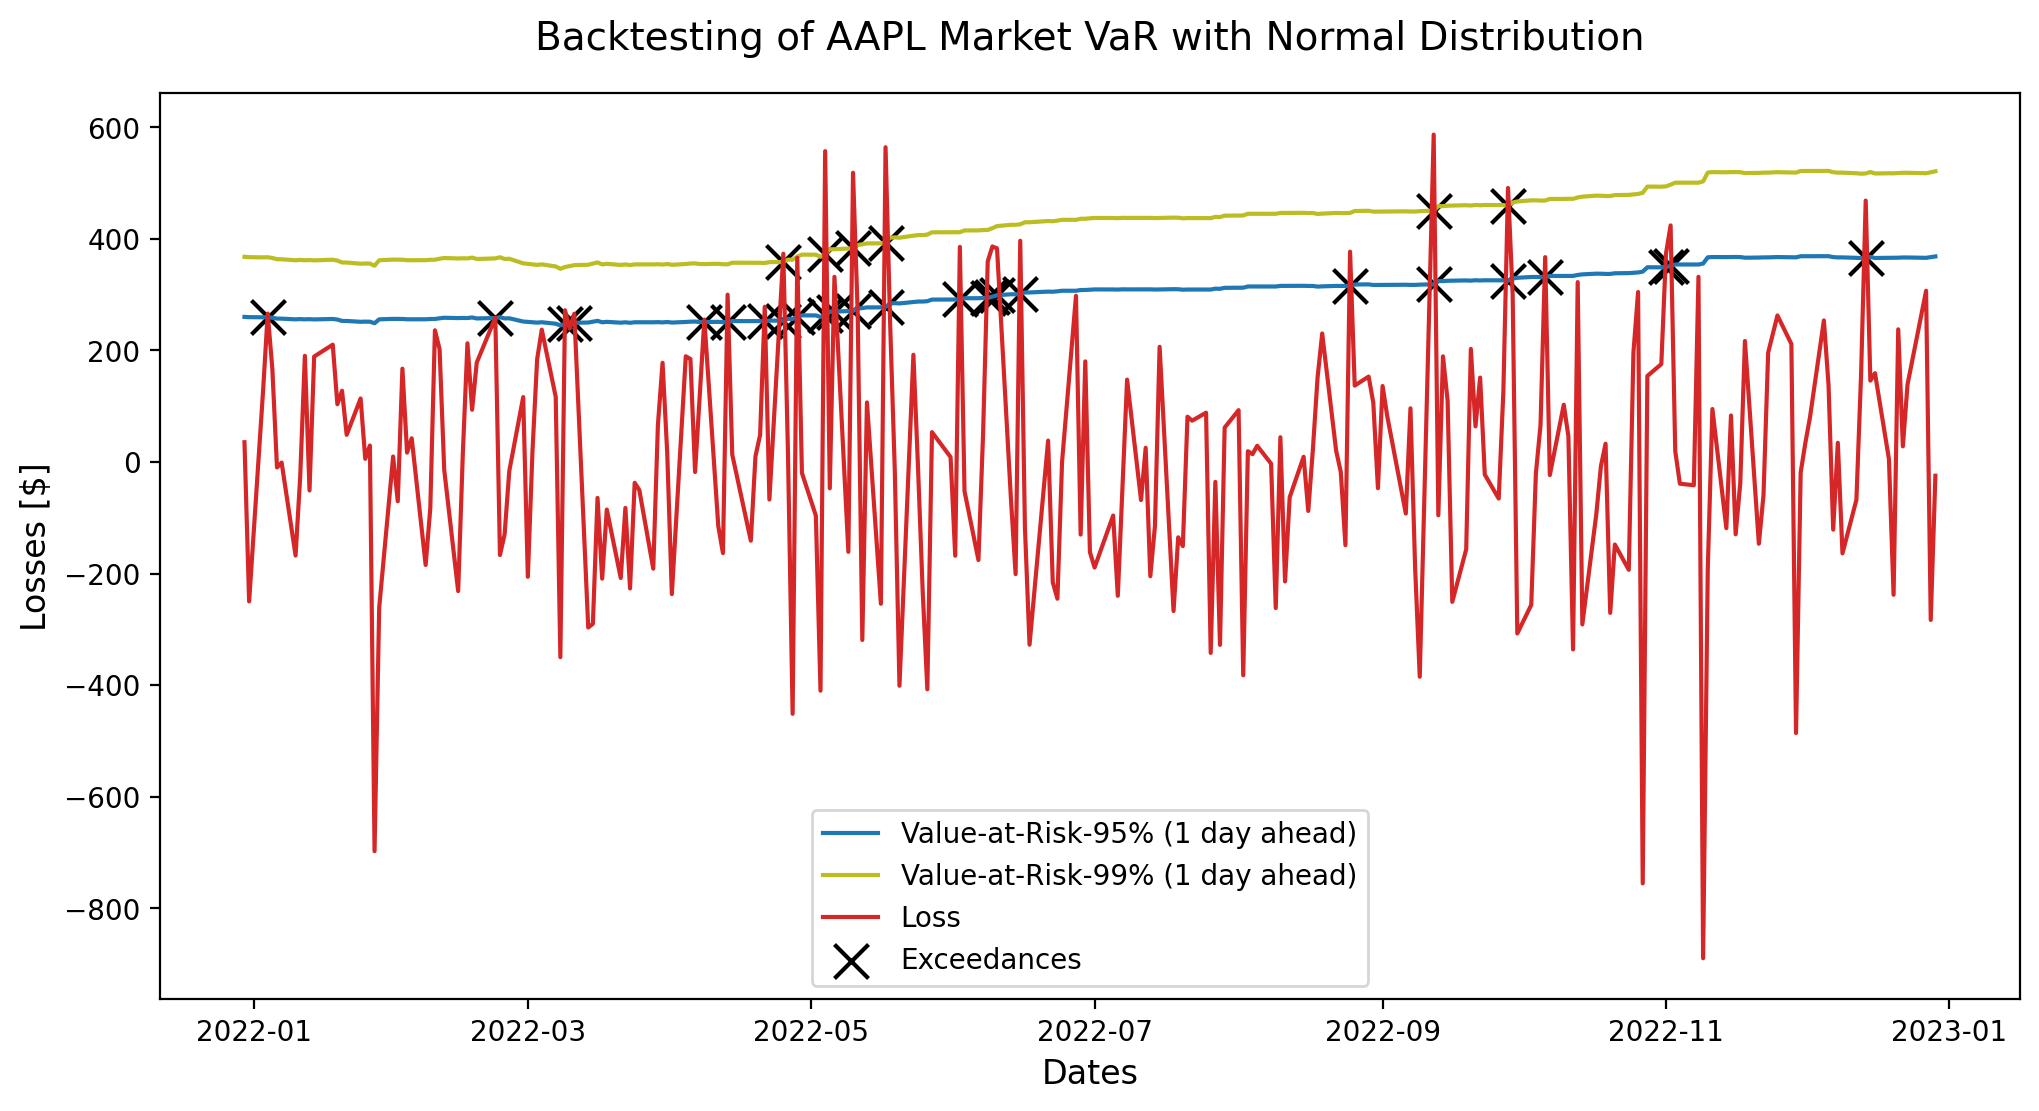

Backtesting results for MSFT:
Number of exceedances at 95% confidence level: 28.0
Number of exceedances at 99% confidence level: 15.0


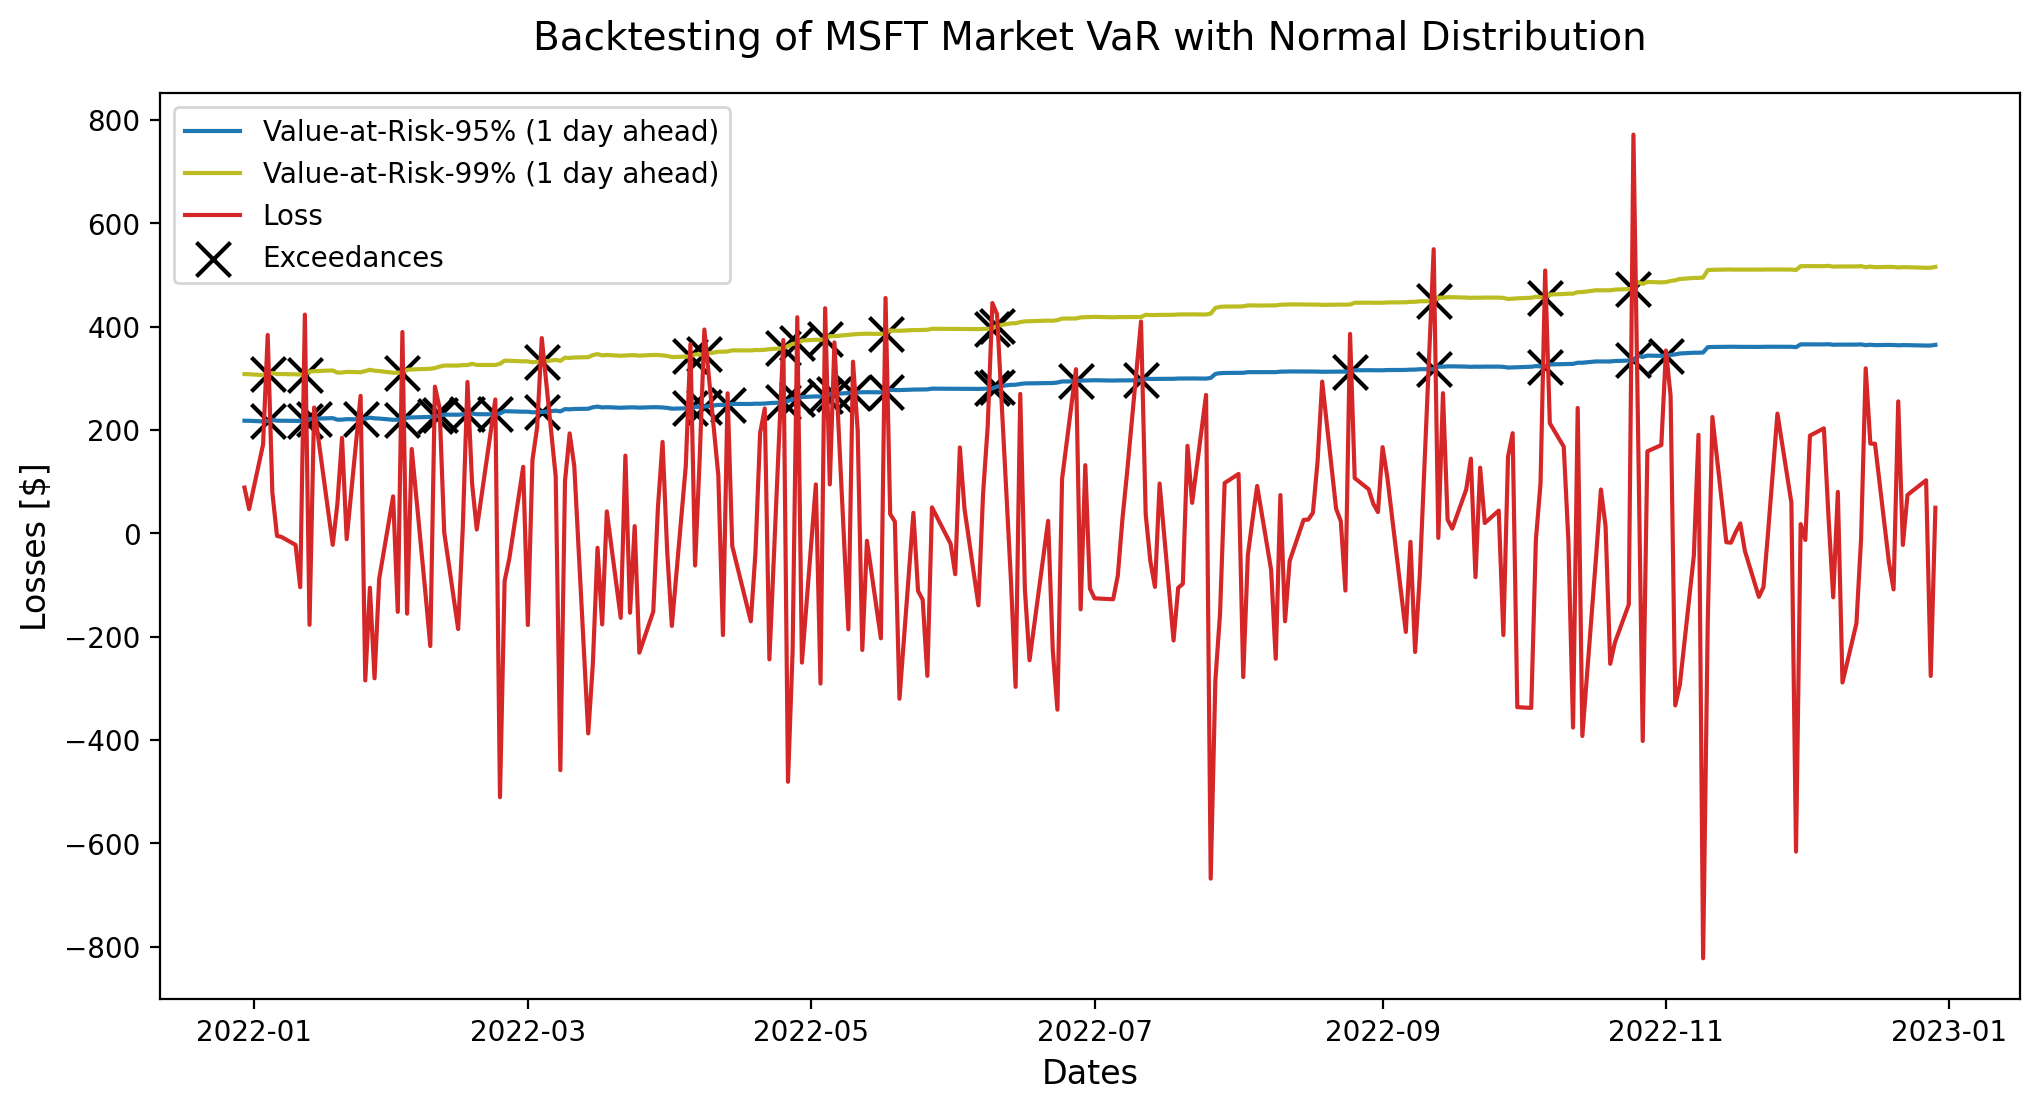

Backtesting results for GOOGL:
Number of exceedances at 95% confidence level: 29.0
Number of exceedances at 99% confidence level: 11.0


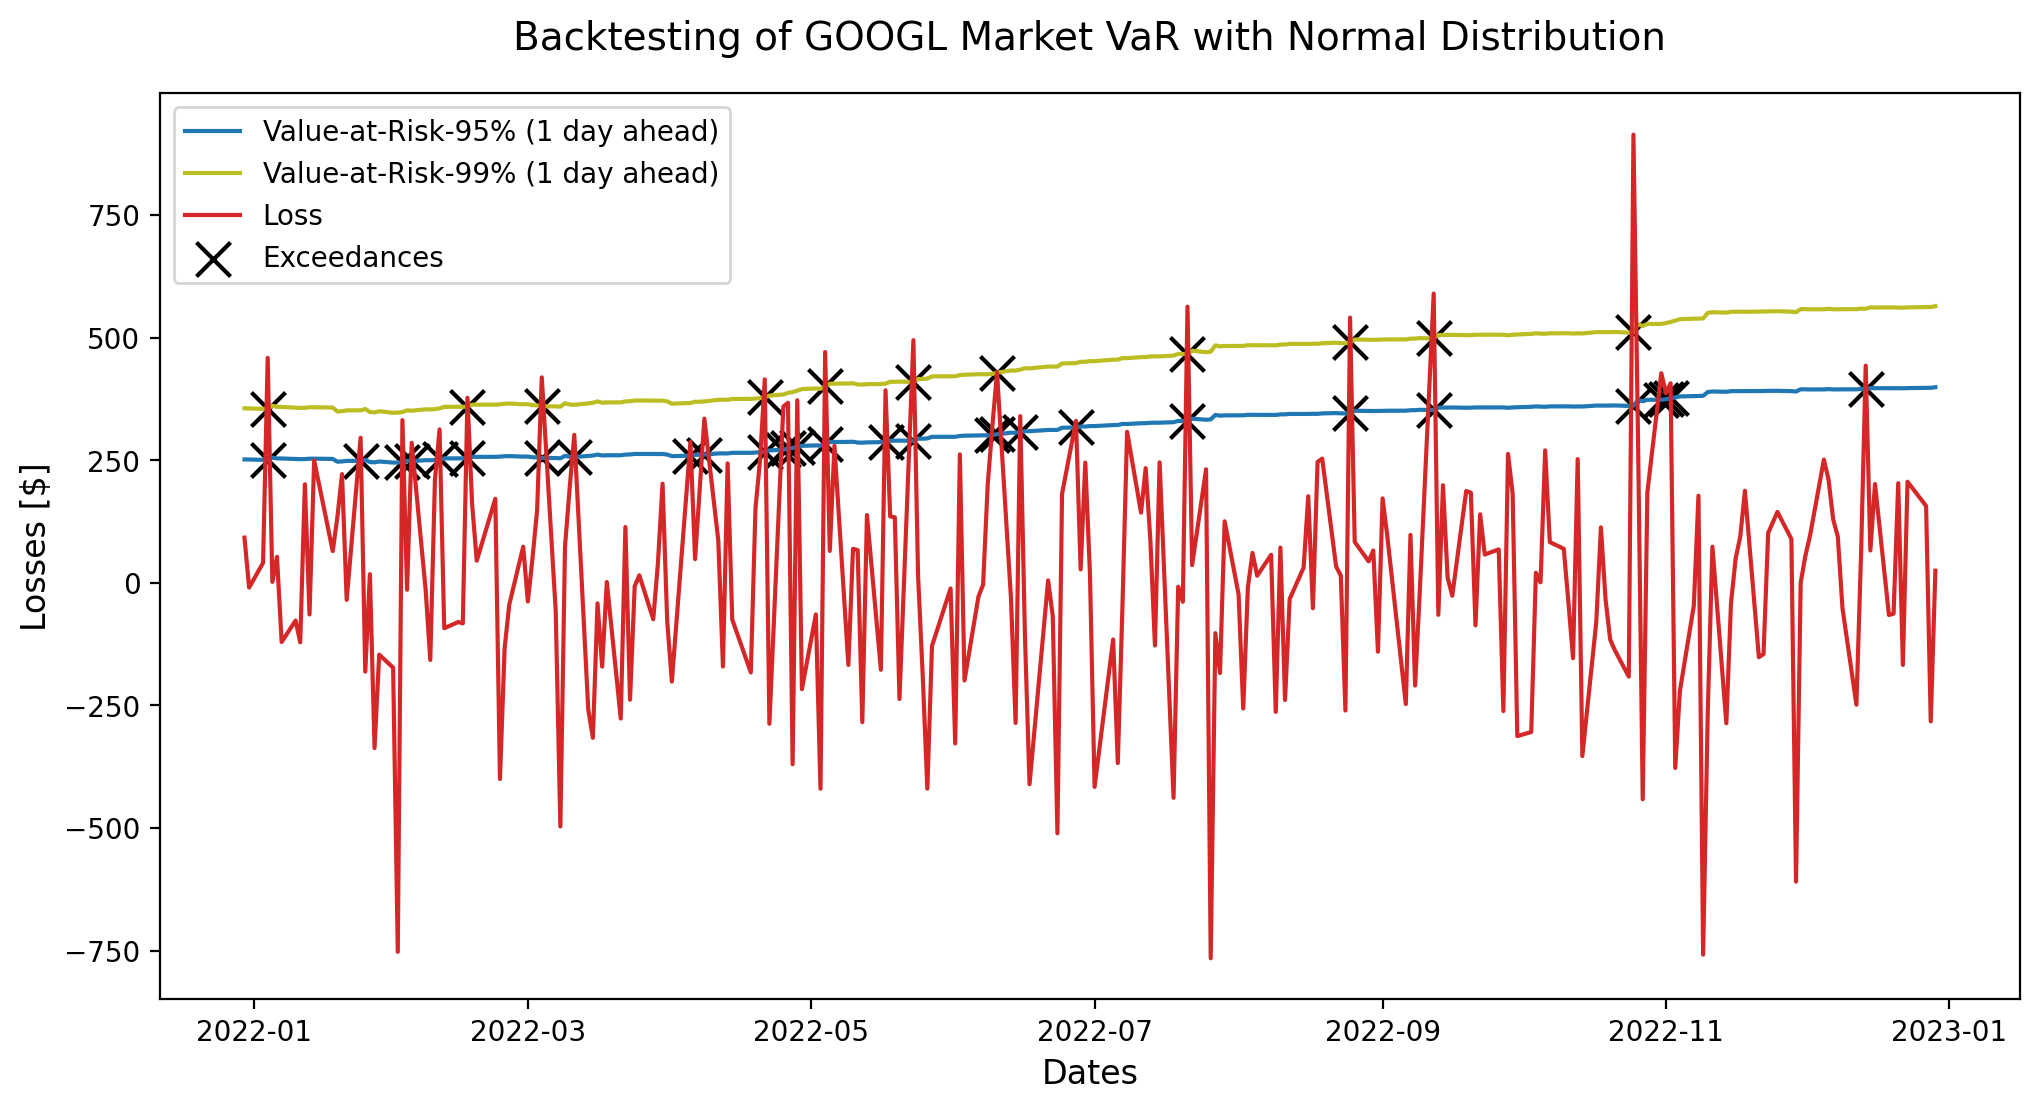

Backtesting results for AMZN:
Number of exceedances at 95% confidence level: 24.0
Number of exceedances at 99% confidence level: 7.0


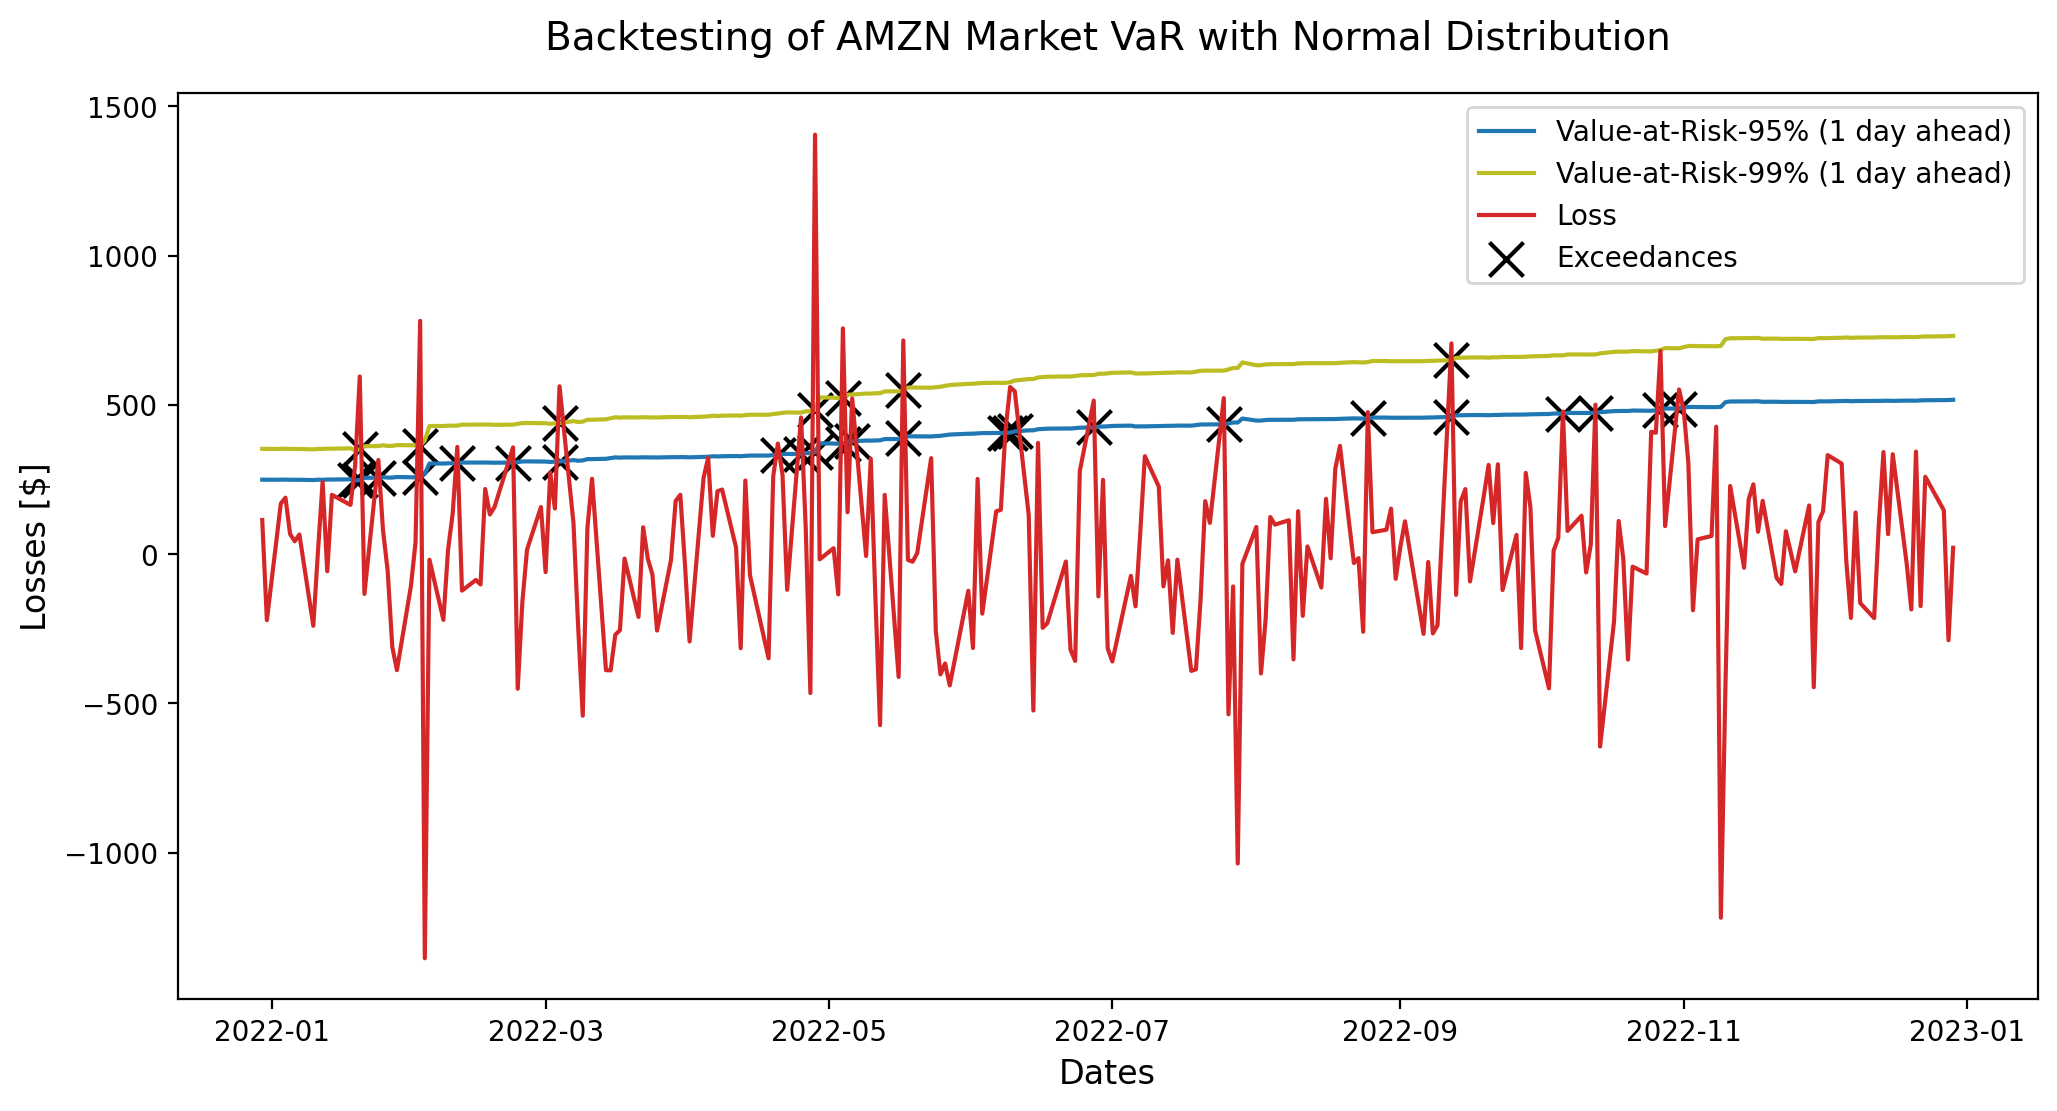

In [57]:
for ticker in tickers:
    ticker_returns = returns[ticker]

    VaR_95_1 = np.zeros(testing_period)
    ES_95_1 = np.zeros(testing_period)
    VaR_99_1 = np.zeros(testing_period)
    ES_99_1 = np.zeros(testing_period)
    exceedance_95 = np.zeros(testing_period)
    exceedance_99 = np.zeros(testing_period)
    loss = np.zeros(testing_period)

    for i in range(0, testing_period, 1):
        mean_return = 0  # Assumption
        used_returns = ticker_returns.values[-(testing_period - i + days_estimate):-(testing_period - i)]
        volatility = np.std(used_returns)

        # Calculate VaR and ES for 95% and 99% confidence levels
        VaR_95_percentage = -volatility * sps.norm.ppf(alpha1, loc=mean_return, scale=1) / 100
        VaR_95 = investment * VaR_95_percentage
        ES_95_percentage = -(volatility * (sps.norm.pdf(sps.norm.ppf(alpha1, loc=mean_return, scale=1)) / alpha1)) / 100
        ES_95 = investment * ES_95_percentage
        VaR_99_percentage = -volatility * sps.norm.ppf(alpha2, loc=mean_return, scale=1) / 100
        VaR_99 = investment * VaR_99_percentage
        ES_99_percentage = -(volatility * (sps.norm.pdf(sps.norm.ppf(alpha2, loc=mean_return, scale=1)) / alpha2)) / 100
        ES_99 = investment * ES_99_percentage

        VaR_95_1[i] = VaR_95
        ES_95_1[i] = ES_95
        VaR_99_1[i] = VaR_99
        ES_99_1[i] = ES_99

        # Calculate losses and exceedances
        loss[i] = -investment * ticker_returns.values[-(testing_period - i)] / 100
        exceedance_95[i] = VaR_95 < loss[i]
        exceedance_99[i] = VaR_99 < loss[i]
    # Display results
    print(f"Backtesting results for {ticker}:")
    print(f"Number of exceedances at 95% confidence level: {np.sum(exceedance_95)}")
    print(f"Number of exceedances at 99% confidence level: {np.sum(exceedance_99)}")

    # Plot the results
    plt.figure(figsize=(12, 6), dpi=200)
    plt.plot(ticker_returns.index[-(testing_period + 1):-1], VaR_95_1, c=mcolors.TABLEAU_COLORS['tab:blue'], label="Value-at-Risk-95% (1 day ahead)")
    plt.plot(ticker_returns.index[-(testing_period + 1):-1], VaR_99_1, c=mcolors.TABLEAU_COLORS['tab:olive'], label="Value-at-Risk-99% (1 day ahead)")
    plt.plot(ticker_returns.index[-(testing_period + 1):-1], loss, c=mcolors.TABLEAU_COLORS['tab:red'], label="Loss")
    plt.scatter(ticker_returns.index[-(testing_period + 1):-1][exceedance_95 == 1], VaR_95_1[exceedance_95 == 1], s=100 * 1.5, marker="x", color="black", label="Exceedances")
    plt.scatter(ticker_returns.index[-(testing_period + 1):-1][exceedance_99 == 1], VaR_99_1[exceedance_99 == 1], s=100 * 1.5, marker="x", color="black")
    plt.xlabel("Dates", fontsize=12)
    plt.ylabel("Losses [$]", fontsize=12)
    plt.title(f"Backtesting of {ticker} Market VaR with Normal Distribution", fontsize=14, y=1.03)
    plt.legend()
    plt.show()


## Parametric model using t distribution

In [41]:

def parametric_t_var_es(returns, alpha, days=252):
    MLE = sps.t.fit(returns.values[-days:])
    var = -sps.t.ppf(alpha, MLE[0], loc=MLE[1], scale=MLE[2]) / 100
    factor1 = (sps.t.pdf(sps.t.ppf(alpha, MLE[0]), MLE[0])) / alpha
    factor2 = (MLE[0] + (sps.t.ppf(alpha, MLE[0]) ** 2)) / (MLE[0] - 1)
    es = (-1 * MLE[1] + MLE[2] * factor1 * factor2) / 100
    return var, es

# Calculate 1-day VaR and ES for each stock using the parametric t-distribution model
for ticker in tickers:
    var_95_t, es_95_t = parametric_t_var_es(returns[ticker], 0.05)
    var_99_t, es_99_t = parametric_t_var_es(returns[ticker], 0.01)
    
    # Calculate actual change for the $1 million investment
    var_95_t_actual = var_95_t * investment
    es_95_t_actual = es_95_t * investment
    var_99_t_actual = var_99_t * investment
    es_99_t_actual = es_99_t * investment
    
    print(f"{ticker} - 95% t-distribution VaR: {var_95_t*100:.2f}% ({var_95_t_actual:.2f} USD), 95% t-distribution ES: {es_95_t*100:.2f}% ({es_95_t_actual:.2f} USD)")
    print(f"{ticker} - 99% t-distribution VaR: {var_99_t*100:.2f}% ({var_99_t_actual:.2f} USD), 99% t-distribution ES: {es_99_t*100:.2f}% ({es_99_t_actual:.2f} USD)")
    print('----------------------------------------------------------------------')

AAPL - 95% t-distribution VaR: 0.04% (375.42 USD), 95% t-distribution ES: 0.05% (493.90 USD)
AAPL - 99% t-distribution VaR: 0.06% (564.69 USD), 99% t-distribution ES: 0.07% (683.21 USD)
----------------------------------------------------------------------
MSFT - 95% t-distribution VaR: 0.04% (371.93 USD), 95% t-distribution ES: 0.05% (489.76 USD)
MSFT - 99% t-distribution VaR: 0.06% (560.08 USD), 99% t-distribution ES: 0.07% (678.33 USD)
----------------------------------------------------------------------
GOOGL - 95% t-distribution VaR: 0.04% (413.46 USD), 95% t-distribution ES: 0.05% (546.76 USD)
GOOGL - 99% t-distribution VaR: 0.06% (625.53 USD), 99% t-distribution ES: 0.08% (763.11 USD)
----------------------------------------------------------------------
AMZN - 95% t-distribution VaR: 0.05% (519.28 USD), 95% t-distribution ES: 0.07% (720.72 USD)
AMZN - 99% t-distribution VaR: 0.08% (832.61 USD), 99% t-distribution ES: 0.11% (1072.33 USD)
----------------------------------------

## Univariate GARCH model applied to portfolio returns

In [42]:

def garch_var_es(returns, alpha, days=252):
    garch = arch_model(returns.values[-days:] / 100, vol='garch', p=1, o=0, q=1)
    garch_fitted = garch.fit()
    garch_forecast = garch_fitted.forecast(horizon=1, reindex=False)
    variance = garch_forecast.variance.values[0][0]

    mean_return = 0
    volatility = np.sqrt(variance)
    var = -volatility * sps.norm.ppf(alpha, loc=mean_return, scale=1)
    es = volatility * (sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1))) / alpha
    return var, es

# Calculate 1-day VaR and ES for each stock using the GARCH model
for ticker in tickers:
    var_95_garch, es_95_garch = garch_var_es(returns[ticker], 0.05)
    var_99_garch, es_99_garch = garch_var_es(returns[ticker], 0.01)
    
    # Calculate actual change for the $1 million investment
    var_95_garch_actual = var_95_garch * investment
    es_95_garch_actual = es_95_garch * investment
    var_99_garch_actual = var_99_garch * investment
    es_99_garch_actual = es_99_garch * investment
    
    print(f"{ticker} - 95% GARCH VaR: {var_95_garch*100:.2f}% ({var_95_garch_actual:.2f} USD), 95% GARCH ES: {es_95_garch*100:.2f}% ({es_95_garch_actual:.2f} USD)")
    print(f"{ticker} - 99% GARCH VaR: {var_99_garch*100:.2f}% ({var_99_garch_actual:.2f} USD), 99% GARCH ES: {es_99_garch*100:.2f}% ({es_99_garch_actual:.2f} USD)")
    print('----------------------------------------------------------------------')

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1761.275968368361
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1761.27596811001
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1761.275968368361
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1761.27596811001
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
AAPL - 95% GARCH VaR: 0.04% (366.06 USD), 95% GARCH ES: 0.05% (459.05 USD)
AAPL - 99% GARCH VaR: 0.05% (517.73 USD), 99% GARCH ES: 0.06% (593.14 USD)
----------------------------------------------------------------------
Iteration:      1,   Func. Count:      5,   Neg. LLF: -1763.221887534673
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1763.2218872867547
            Iterations: 1
            Fun

/home/oscar/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/oscar/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/oscar/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/home/oscar/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  Converge

### Backtesting 